In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
#######
import sklearn.cluster
from sklearn.metrics.pairwise import euclidean_distances
import sklearn.metrics
import sklearn.linear_model
from sklearn.preprocessing import StandardScaler

In [2]:
class RBFNetwork(object):
    """Rede Neural com Funções de Base Radial com uma única camada oculta.
    
    Essa é uma rede com três camadas.
        1) Camada de Entrada: Recebe os atributos usados como input.
        2) Camada Oculta: Aplica transformações não lineares sobre os dados
        de entrada, dadas pelo kernel para cada um dos centróides,
        ampliando o espaço de entrada para o espaço da rede oculta.
        3) Camada de Saída: Realiza a combinação linear das saídas da Camada
        Oculta.
        
    TREINAMENTO:
    Essa implementação utiliza o Kernel Gaussiano para a transformação da 
    camada oculta. São escolhidos number_of_centers centroides através do 
    K-Means sobre os dados de treinamento, com K = number_of_centers. 
    Para a execução do K-Means, foi utilizada a implementação do 
    sklearn.cluster.KMeans, iniciado com n_clusters = self.number_of_centers e
    random_state = self.random_state.

    Após o fit do KMeans, obteu-se os centros das agregações e, para
    cada agregação, o desvio padrão entre as observações daquela agregação
    e seu centro.

    Com esses valores, criou-se number_of_centers funções gaussianas, 
    centradas nos centros encontrados e com o parâmetro sigma igual ao
    desvio padrão.

    Em seguida, os dados de entrada são transformados para o espaço da camada
    oculta, aplicando o kernel para cada uma das observações. Por precaução,
     transforma-se os valores nan em 0. Esses dados são armazenados numa nova
     features_array, que representa os valores na Camada Oculta.

    Para realizar o ajuste dos pesos entre a Camada Oculta e a Camada de Saída,
    composta de um único neurônio, utilizou-se a classe do scikit-learn
    sklearn.linear_model.LinearRegression, com a features_array e os valores de
    y.

    PREDIÇÕES
    Uma vez que a classe esteja treinada, as predições são realizadas da seguinte
    forma:
        1) Transforma-se os valores de entrada para a Camada Oculta(features_array) utilizando
        os kernels calculados no treinamento.
        2) Utiliza-se os valores da Camada Oculta como entrada para o regressor
        linear treinado(sklearn.linear_model.LinearRegression).
        3) Retorna o resultado da regressão linear.
    
    Parameters
    ----------
    number_of_centers: integer, required
        O número de centróides/neurônios que existirão na Camada Oculta.
    random_state: integer, optional, default = 42
        Determina o número usado para o estado aleatório do K=Means.
    """

    def __init__(self, number_of_centers, random_state=42):
        """[summary]
                
        Arguments:
            number_of_centers {integer} -- The number of the centers
        
        Keyword Arguments:
            random_state {int} -- Random state, to be used with the internal algorithms (default: {42})
        """        

        self.number_of_centers = number_of_centers
        self.centers = None
        self.centers_std = None
        self.kernels = None
        self.random_state = random_state
        # Usado para fazer o ajuste linear após a alteração do espaço de entrada
        self.algorithm = sklearn.linear_model.LinearRegression()

    @staticmethod
    def make_gaussian_kernel(center, sigma):
        ''' Creates a Gaussian Kernel function that takes X and calculate the
        distance from the center with the sigma deviation. 
        '''
        variance = sigma**2
        if(variance == 0):
             variance = 1e-10
        gamma = 2*(variance)
        reshaped_center = np.reshape(center, newshape=(1, -1))

        def gaussian(X):
            dist = euclidean_distances(X, reshaped_center, squared=True)
            normalization_constant = 1/(2*np.pi*variance)
            return normalization_constant * np.exp(-(dist/gamma))
        return gaussian

    def fit(self, X, y):
        """
        Faz o ajuste da rede artificial RBF. 

        
        Essa implementação utiliza o Kernel Gaussiano para a transformação da 
        camada oculta. São escolhidos number_of_centers centroides através do 
        K-Means sobre os dados de treinamento, com K = number_of_centers. 
        Para a execução do K-Means, foi utilizada a implementação do 
        sklearn.cluster.KMeans, iniciado com n_clusters = self.number_of_centers e
        random_state = self.random_state.

        Após o fit do KMeans, obteu-se os centros das agregações e, para
        cada agregação, o desvio padrão entre as observações daquela agregação
        e seu centro.

        Com esses valores, criou-se number_of_centers funções gaussianas, 
        centradas nos centros encontrados e com o parâmetro sigma igual ao
        desvio padrão.

        Em seguida, os dados de entrada são transformados para o espaço da camada
        oculta, aplicando o kernel para cada uma das observações. Por precaução,
        transforma-se os valores nan em 0. Esses dados são armazenados numa nova
        features_array, que representa os valores na Camada Oculta.

        Para realizar o ajuste dos pesos entre a Camada Oculta e a Camada de Saída,
        composta de um único neurônio, utilizou-se a classe do scikit-learn
        sklearn.linear_model.LinearRegression, com a features_array e os valores de
        y.

        Parameters
        ----------
        X: Atributos fornecidos para o treinamento do algoritmo
        y: Valores alvo para o algoritmo.
        """
        self._fit_centers(X, y)
        self._generate_radial_functions()

        transformed_X = self._transformed_inputs(X)
        self._linear_fit(transformed_X, y)

    def predict(self, X):
        """Função usada para a predição dos valores.
    
        Uma vez que a classe esteja treinada, as predições são realizadas da seguinte
        forma:
            1) Transforma-se os valores de entrada para a Camada Oculta(features_array) utilizando
            os kernels calculados no treinamento.
            2) Utiliza-se os valores da Camada Oculta como entrada para o regressor
            linear treinado(sklearn.linear_model.LinearRegression).
            3) Retorna o resultado da regressão linear.
        
        Parameter
        ---------
        X: Atributos que alimentarão a Camada de Entrada.
        """
        transformed_X = self._transformed_inputs(X)
        return (self.algorithm.predict(transformed_X))

    def _fit_centers(self, X, y=None):
        """Essa função obtem o centróides e os desvios padrão utilizados
        para calcular os kernels."""
        kmeans = sklearn.cluster.KMeans(n_clusters=self.number_of_centers,
                                        random_state=self.random_state)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        groups = kmeans.predict(X)

        center_distances = euclidean_distances(X, self.centers)
        center_distances_df = pd.DataFrame(center_distances)
        center_distances_df['classe'] = groups

        # Calculate the std from the center
        # Note that the center_distances_df has the distance from each center
        center_distances_std = center_distances_df.groupby('classe').std()
        self.centers_std = np.diag(center_distances_std)

    def _generate_radial_functions(self):
        """Essa função cria a lista de kernels usada para gerar a Camada Oculta."""
        self.kernels = list()
        for cluster_center, cluster_deviance in zip(self.centers, self.centers_std):
            kernel = self.make_gaussian_kernel(
                cluster_center, cluster_deviance)#mexi aqui
            self.kernels.append(kernel)

    def _transformed_inputs(self, X):
        """Transforma os dados do Espaço de Entrada para o Espaço da Camada Oculta.
        
        Essa função aplica os kernels da RBFN nos dados de entrada, criando uma array
        que representa os valores na camada oculta.

        Parameters
        ----------
        X: Valores dos atributos de entrada, que deverão ser convertidos para 
        valores na camada oculta pelas funções de kernel.
        """
        features = [kernel(X) for kernel in self.kernels]
        features_array = (np.concatenate(features, axis=1))
        features_array = np.nan_to_num(x = features_array) # mexi aqui
        return features_array

    def _linear_fit(self, hidden_X, y):
        """Realiza o ajuste dos pesos que ligam a Camada Oculta à Camada De Saída.
        
        O ajuste é realizado através do algoritmo sklearn.linear_model.LinearRegression.
        
        Parameters
        ----------
        hidden_X: Os valores da Camada Oculta, ou seja, os valores de entrada
        transformados para a camada oculta. Seja X a matriz que contém os valores
        que entram na Camada de Entrada: 
            hidden_X = _self._transformed_inputs(X) """
        self.algorithm.fit(hidden_X, y)


In [3]:
db = pd.read_csv("C:/Users/thale/Desktop/Faculdade_e_Trabalho/IC/IC2019/Regressões/SolarPrediction.csv")
db = db.sort_values(['UNIXTime'], ascending = [True])
from datetime import datetime   #funções das 6 primeiras linhas
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu') #
db.index =  pd.to_datetime(db['UNIXTime'], unit='s')
db.index = db.index.tz_localize(pytz.utc).tz_convert(hawaii)
db['MonthOfYear'] = db.index.strftime('%m').astype(int)
db['DayOfYear'] = db.index.strftime('%j').astype(int)
db['WeekOfYear'] = db.index.strftime('%U').astype(int)
db['TimeOfDay(h)'] = db.index.hour
db['TimeOfDay(m)'] = db.index.hour*60 + db.index.minute
db['TimeOfDay(s)'] = db.index.hour*60*60 + db.index.minute*60 + db.index.second
db.drop(['Data','Time','UNIXTime'], inplace=True, axis=1)
db

,Radiation1,Radiation2,Radiation3,Radiation4,Radiation5,Radiation6,Y,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,MonthOfYear,DayOfYear,WeekOfYear,TimeOfDay(h),TimeOfDay(m),TimeOfDay(s)
UNIXTime,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,2.58,1.26,1.26,1.26,1.29,1.26,1.21,51,30.43,103,77.27,11.25,0.254861,0.776389,9,245,35,0,0,8
2016-09-01 00:05:10-10:00,2.83,2.58,1.26,1.26,1.26,1.29,1.26,51,30.43,103,153.44,9.00,0.254861,0.776389,9,245,35,0,5,310
2016-09-01 00:20:06-10:00,2.16,2.83,2.58,1.26,1.26,1.26,1.29,51,30.43,103,142.04,7.87,0.254861,0.776389,9,245,35,0,20,1206
2016-09-01 00:25:05-10:00,2.21,2.16,2.83,2.58,1.26,1.26,1.26,51,30.43,103,144.12,18.00,0.254861,0.776389,9,245,35,0,25,1505
2016-09-01 00:30:09-10:00,2.25,2.21,2.16,2.83,2.58,1.26,1.26,51,30.43,103,67.42,11.25,0.254861,0.776389,9,245,35,0,30,1809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:35:02-10:00,1.22,1.20,1.19,1.22,1.18,1.20,1.22,41,30.34,83,238.94,6.75,0.289583,0.745833,12,366,52,23,1415,84902
2016-12-31 23:40:01-10:00,1.21,1.22,1.20,1.19,1.22,1.18,1.20,41,30.34,82,236.79,5.62,0.289583,0.745833,12,366,52,23,1420,85201
2016-12-31 23:45:04-10:00,1.21,1.21,1.22,1.20,1.19,1.22,1.18,42,30.34,81,218.28,7.87,0.289583,0.745833,12,366,52,23,1425,85504


In [4]:
X = db.drop('Y', axis = 1)
X = StandardScaler().fit_transform(X)
y = db['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
rbfNetwork = RBFNetwork(50)
#for i in range(0,2):
rbfNetwork.fit(X_train,y_train)

Resultados
Mean squared error: 79154.34
Variance score: 0.20


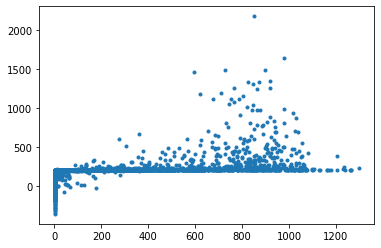

In [5]:
y_predict= rbfNetwork.predict(X_test)
print("Resultados")
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_predict))
print('Variance score: %.2f' % r2_score(y_test, y_predict))
plt.scatter(y_test,y_predict,marker='.')
plt.show()

teste de overfiting
Mean squared error: 78559.85
Variance score: 0.21


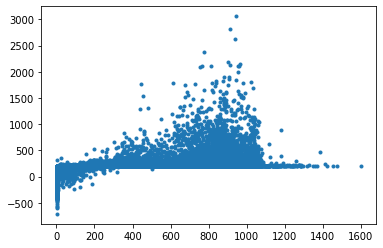

In [6]:
y_predict_train = rbfNetwork.predict(X_train)
print("teste de overfiting")
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, y_predict_train))
print('Variance score: %.2f' % r2_score(y_train, y_predict_train))
plt.scatter(y_train,y_predict_train,marker='.')
plt.show()
